<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Learning_Schedules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning Rate Schedules

This notebook provides a comprehensive exploration of learning rate scheduling strategies in deep learning optimisation. Having built optimisers that determine how gradients update parameters, i now examine how the learning rate, the scaling factor controlling update magnitude, should evolve during training. We begin with theoretical foundations connecting learning rate to convergence guarantees in convex and non-convex optimization, then implement six major scheduling strategies from scratch: step decay, exponential decay, cosine annealing, linear warmup, cyclical learning rates, and the OneCycleLR policy. Our experimental framework demonstrates how schedule choice affects convergence speed, final accuracy, and loss landscape navigation on MNIST using the same deep network architecture from previous days. The analysis connects scheduling theory to broader research themes including neural architecture search (where schedule interacts with weight sharing dynamics), knowledge distillation (where teacher-student learning rates may require coordination), and efficient training (where proper scheduling can dramatically reduce total compute).

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Callable, Tuple
from dataclasses import dataclass
from abc import ABC, abstractmethod
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

I implement each scheduler as a class that tracks the current step and computes the appropriate learning rate. All schedulers follow a common interface for easy comparison.

In [47]:
class BaseLRScheduler(ABC):

    def __init__(self, optimizer: torch.optim.Optimizer, base_lr: float):
        """
        Initialize the scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Initial/base learning rate
        """
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.current_step = 0
        self.lr_history = []

        # Set initial LR
        self._set_lr(base_lr)

    def _set_lr(self, lr: float):
        """Apply learning rate to all parameter groups."""
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.lr_history.append(lr)

    def get_lr(self) -> float:
        """Get current learning rate."""
        return self.optimizer.param_groups[0]['lr']

    @abstractmethod
    def _compute_lr(self) -> float:
        """Compute learning rate for current step. Override in subclasses."""
        pass

    def step(self):
        """Advance one step and update learning rate."""
        self.current_step += 1
        lr = self._compute_lr()
        self._set_lr(lr)

    def reset(self):
        """Reset scheduler to initial state."""
        self.current_step = 0
        self.lr_history = []
        self._set_lr(self.base_lr)

In [48]:
class StepDecayScheduler(BaseLRScheduler):


    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        step_size: int,
        gamma: float = 0.1
    ):
        """
        Initialize Step Decay scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Initial learning rate
            step_size: Steps between decays (often epochs * steps_per_epoch)
            gamma: Decay factor (0.1 means divide by 10)
        """
        self.step_size = step_size
        self.gamma = gamma
        super().__init__(optimizer, base_lr)

    def _compute_lr(self) -> float:
        """Compute LR with step decay."""
        num_decays = self.current_step // self.step_size
        return self.base_lr * (self.gamma ** num_decays)

In [49]:
class ExponentialDecayScheduler(BaseLRScheduler):


    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        gamma: float = 0.9999
    ):
        """
        Initialize Exponential Decay scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Initial learning rate
            gamma: Per-step decay factor (should be close to 1)
        """
        self.gamma = gamma
        super().__init__(optimizer, base_lr)

    def _compute_lr(self) -> float:
        """Compute LR with exponential decay."""
        return self.base_lr * (self.gamma ** self.current_step)

    @classmethod
    def from_final_lr(
        cls,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        final_lr: float,
        total_steps: int
    ) -> 'ExponentialDecayScheduler':
        """
        Create scheduler that decays to a specific final LR.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Initial learning rate
            final_lr: Target final learning rate
            total_steps: Total training steps

        Returns:
            Configured ExponentialDecayScheduler
        """
        gamma = (final_lr / base_lr) ** (1.0 / total_steps)
        return cls(optimizer, base_lr, gamma)

In [50]:
class CosineAnnealingScheduler(BaseLRScheduler):

    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        T_max: int,
        eta_min: float = 0.0
    ):
        """
        Initialize Cosine Annealing scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Maximum learning rate (η_max)
            T_max: Steps for complete cosine cycle
            eta_min: Minimum learning rate (default 0)
        """
        self.T_max = T_max
        self.eta_min = eta_min
        super().__init__(optimizer, base_lr)

    def _compute_lr(self) -> float:
        """Compute LR with cosine annealing."""
        # Clamp to T_max to avoid issues if training continues past T_max
        t = min(self.current_step, self.T_max)

        cos_value = math.cos(math.pi * t / self.T_max)
        return self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + cos_value)

In [51]:
class CosineAnnealingWarmRestartsScheduler(BaseLRScheduler):


    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        T_0: int,
        T_mult: int = 1,
        eta_min: float = 0.0
    ):
        """
        Initialize SGDR scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Maximum learning rate at restart
            T_0: Initial cycle length in steps
            T_mult: Cycle length multiplier (1 = constant length)
            eta_min: Minimum learning rate
        """
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        super().__init__(optimizer, base_lr)

    def _compute_lr(self) -> float:
        """Compute LR with warm restarts."""
        if self.T_mult == 1:
            # Simple case: constant cycle length
            T_cur = self.current_step % self.T_0
            T_i = self.T_0
        else:
            # Variable cycle length
            # Find which cycle we're in and position within it
            step = self.current_step
            T_i = self.T_0
            T_cur = step

            while T_cur >= T_i:
                T_cur -= T_i
                T_i *= self.T_mult

        cos_value = math.cos(math.pi * T_cur / T_i)
        return self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + cos_value)

In [52]:
class LinearWarmupScheduler(BaseLRScheduler):


    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        warmup_steps: int,
        start_lr: float = 0.0,
        post_warmup_scheduler: Optional[BaseLRScheduler] = None
    ):
        """
        Initialize Linear Warmup scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Target learning rate after warmup
            warmup_steps: Number of warmup steps
            start_lr: Initial learning rate (default 0)
            post_warmup_scheduler: Scheduler to use after warmup (optional)
        """
        self.warmup_steps = warmup_steps
        self.start_lr = start_lr
        self.post_warmup_scheduler = post_warmup_scheduler
        super().__init__(optimizer, start_lr)  # Start at start_lr

    def _compute_lr(self) -> float:
        """Compute LR with linear warmup."""
        if self.current_step < self.warmup_steps:
            # Linear interpolation from start_lr to base_lr
            progress = self.current_step / self.warmup_steps
            return self.start_lr + progress * (self.base_lr - self.start_lr)
        else:
            # After warmup
            if self.post_warmup_scheduler is not None:
                # Delegate to post-warmup scheduler
                self.post_warmup_scheduler.current_step = self.current_step - self.warmup_steps
                return self.post_warmup_scheduler._compute_lr()
            else:
                # Constant at base_lr
                return self.base_lr

In [53]:
class CyclicLRScheduler(BaseLRScheduler):


    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        max_lr: float,
        step_size_up: int,
        step_size_down: Optional[int] = None,
        mode: str = 'triangular',
        gamma: float = 0.99994
    ):
        """
        Initialize Cyclical LR scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Minimum LR (lower bound of cycle)
            max_lr: Maximum LR (upper bound of cycle)
            step_size_up: Steps in the increasing half of cycle
            step_size_down: Steps in decreasing half (default: same as up)
            mode: 'triangular', 'triangular2', or 'exp_range'
            gamma: Decay factor for exp_range (applied each step)
        """
        self.max_lr = max_lr
        self.step_size_up = step_size_up
        self.step_size_down = step_size_down or step_size_up
        self.mode = mode
        self.gamma = gamma

        self.cycle_length = self.step_size_up + self.step_size_down

        super().__init__(optimizer, base_lr)

    def _compute_lr(self) -> float:
        """Compute LR with cyclical schedule."""
        # Position within current cycle
        cycle = self.current_step // self.cycle_length
        step_in_cycle = self.current_step % self.cycle_length

        # Compute position in [0, 1] within cycle
        if step_in_cycle < self.step_size_up:
            # Ascending phase
            x = step_in_cycle / self.step_size_up
        else:
            # Descending phase
            x = 1.0 - (step_in_cycle - self.step_size_up) / self.step_size_down

        # Compute amplitude based on mode
        if self.mode == 'triangular':
            amplitude = self.max_lr - self.base_lr
        elif self.mode == 'triangular2':
            amplitude = (self.max_lr - self.base_lr) / (2 ** cycle)
        elif self.mode == 'exp_range':
            amplitude = (self.max_lr - self.base_lr) * (self.gamma ** self.current_step)
        else:
            raise ValueError(f"Unknown mode: {self.mode}")

        return self.base_lr + amplitude * x

In [54]:
class OneCycleLRScheduler(BaseLRScheduler):

    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        max_lr: float,
        total_steps: int,
        pct_start: float = 0.3,
        div_factor: float = 25.0,
        final_div_factor: float = 10000.0,
        anneal_strategy: str = 'cos'
    ):
        """
        Initialize OneCycleLR scheduler.

        Args:
            optimizer: Optimizer to schedule
            max_lr: Maximum learning rate at peak
            total_steps: Total training steps
            pct_start: Fraction of steps for increasing phase
            div_factor: Divide max_lr by this for initial LR
            final_div_factor: Divide max_lr by this for final LR
            anneal_strategy: 'cos' for cosine, 'linear' for linear decay
        """
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.anneal_strategy = anneal_strategy

        self.initial_lr = max_lr / div_factor
        self.final_lr = max_lr / final_div_factor
        self.step_up = int(total_steps * pct_start)
        self.step_down = total_steps - self.step_up

        super().__init__(optimizer, self.initial_lr)

    def _compute_lr(self) -> float:
        """Compute LR with OneCycle policy."""
        if self.current_step < self.step_up:
            # Phase 1: Increase from initial_lr to max_lr
            progress = self.current_step / self.step_up
            if self.anneal_strategy == 'cos':
                # Cosine interpolation
                return self.initial_lr + (self.max_lr - self.initial_lr) * \
                       (1 - math.cos(math.pi * progress)) / 2
            else:
                # Linear interpolation
                return self.initial_lr + (self.max_lr - self.initial_lr) * progress
        else:
            # Phase 2: Decrease from max_lr to final_lr
            progress = (self.current_step - self.step_up) / self.step_down
            progress = min(progress, 1.0)  # Clamp if we go past total_steps

            if self.anneal_strategy == 'cos':
                # Cosine interpolation
                return self.final_lr + (self.max_lr - self.final_lr) * \
                       (1 + math.cos(math.pi * progress)) / 2
            else:
                # Linear interpolation
                return self.max_lr - (self.max_lr - self.final_lr) * progress


In [55]:
class WarmupCosineScheduler(BaseLRScheduler):


    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        base_lr: float,
        warmup_steps: int,
        total_steps: int,
        min_lr: float = 0.0
    ):
        """
        Initialize Warmup + Cosine scheduler.

        Args:
            optimizer: Optimizer to schedule
            base_lr: Maximum learning rate (reached after warmup)
            warmup_steps: Number of warmup steps
            total_steps: Total training steps
            min_lr: Final learning rate
        """
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        self.decay_steps = total_steps - warmup_steps
        super().__init__(optimizer, 0.0)  # Start at 0
        self.target_lr = base_lr  # Store the target

    def _compute_lr(self) -> float:
        """Compute LR with warmup + cosine decay."""
        if self.current_step < self.warmup_steps:
            # Warmup phase: linear increase
            return self.target_lr * (self.current_step / self.warmup_steps)
        else:
            # Cosine decay phase
            progress = (self.current_step - self.warmup_steps) / self.decay_steps
            progress = min(progress, 1.0)
            cos_value = math.cos(math.pi * progress)
            return self.min_lr + 0.5 * (self.target_lr - self.min_lr) * (1 + cos_value)

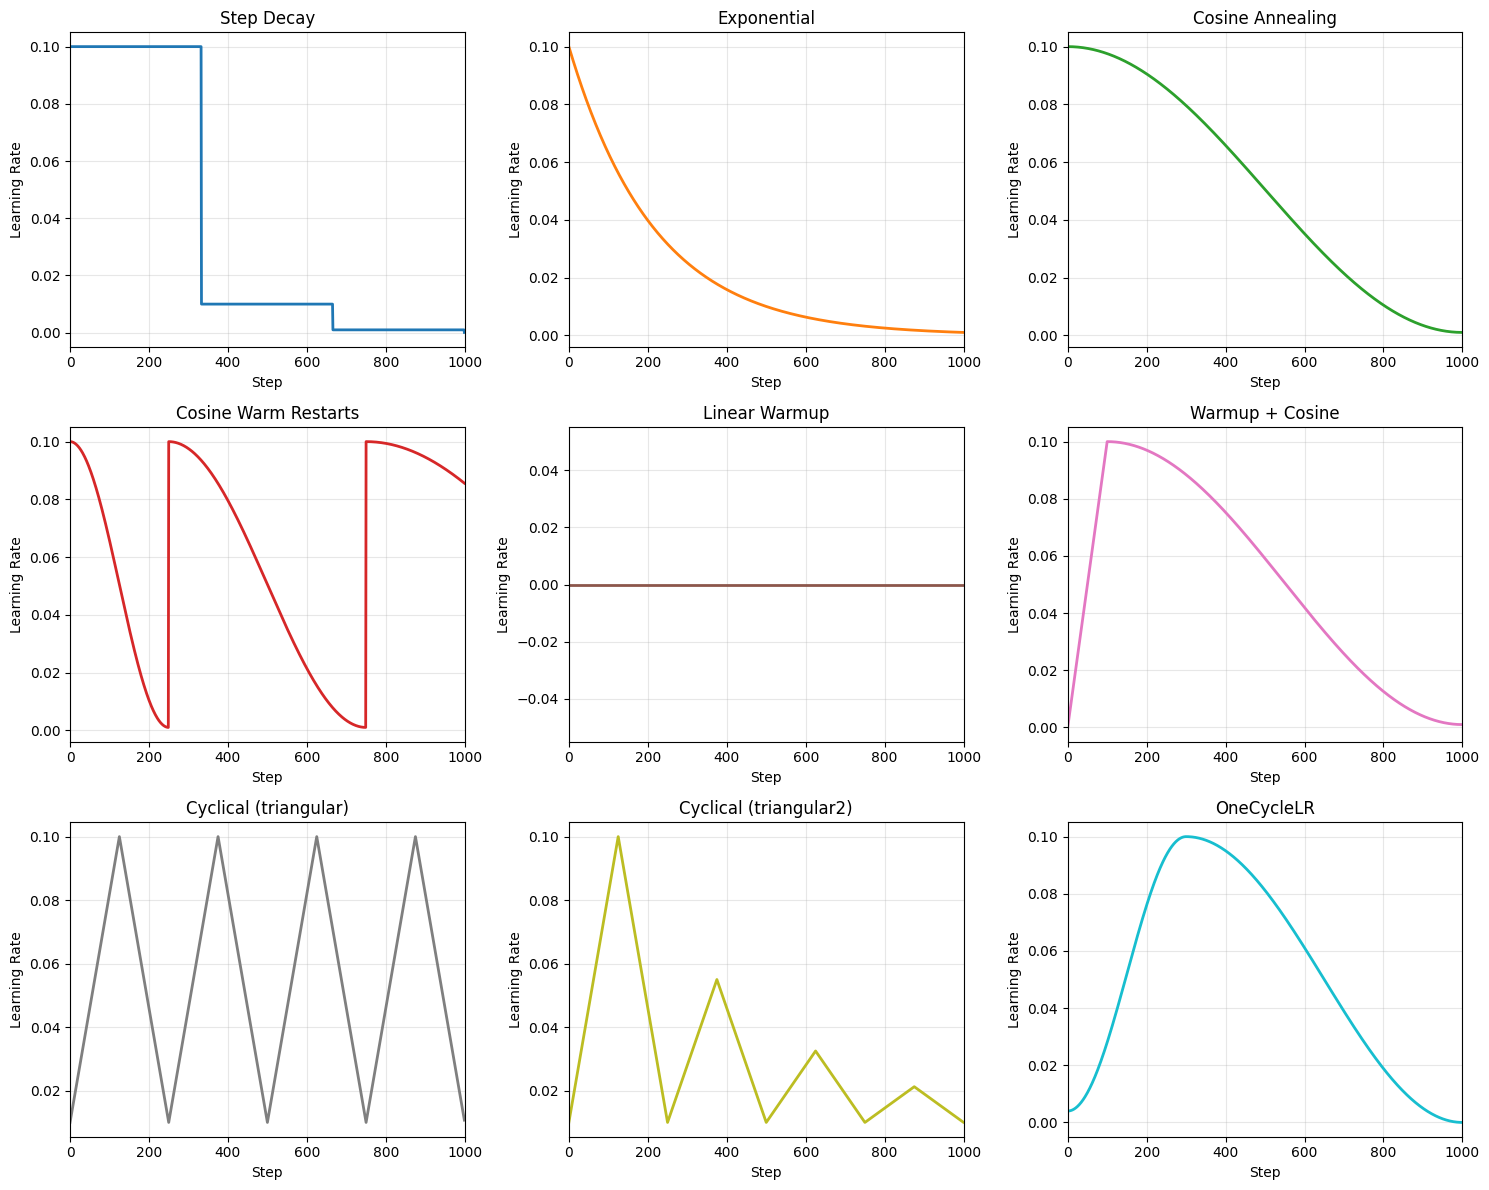

In [56]:
# Visualize all schedules

def visualize_schedules(total_steps: int = 1000):
    """
    Visualize all implemented learning rate schedules.

    Creates comparison plots showing how each schedule varies over training.
    """
    # Create a dummy optimizer
    dummy_model = nn.Linear(10, 10)

    schedules = [
        ('Step Decay', StepDecayScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            base_lr=0.1, step_size=total_steps//3, gamma=0.1
        )),
        ('Exponential', ExponentialDecayScheduler.from_final_lr(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            base_lr=0.1, final_lr=0.001, total_steps=total_steps
        )),
        ('Cosine Annealing', CosineAnnealingScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            base_lr=0.1, T_max=total_steps, eta_min=0.001
        )),
        ('Cosine Warm Restarts', CosineAnnealingWarmRestartsScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            base_lr=0.1, T_0=total_steps//4, T_mult=2, eta_min=0.001
        )),
        ('Linear Warmup', LinearWarmupScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            base_lr=0.1, warmup_steps=total_steps//10
        )),
        ('Warmup + Cosine', WarmupCosineScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            base_lr=0.1, warmup_steps=total_steps//10,
            total_steps=total_steps, min_lr=0.001
        )),
        ('Cyclical (triangular)', CyclicLRScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.01),
            base_lr=0.01, max_lr=0.1, step_size_up=total_steps//8, mode='triangular'
        )),
        ('Cyclical (triangular2)', CyclicLRScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.01),
            base_lr=0.01, max_lr=0.1, step_size_up=total_steps//8, mode='triangular2'
        )),
        ('OneCycleLR', OneCycleLRScheduler(
            torch.optim.SGD(dummy_model.parameters(), lr=0.1),
            max_lr=0.1, total_steps=total_steps, pct_start=0.3
        )),
    ]

    # Run each schedule
    lr_curves = {}
    for name, scheduler in schedules:
        lrs = [scheduler.get_lr()]
        for _ in range(total_steps):
            scheduler.step()
            lrs.append(scheduler.get_lr())
        lr_curves[name] = lrs[:total_steps]

    # Plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    colors = plt.cm.tab10(np.linspace(0, 1, len(schedules)))

    for idx, (name, lrs) in enumerate(lr_curves.items()):
        ax = axes[idx]
        ax.plot(lrs, color=colors[idx], linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel('Learning Rate')
        ax.set_title(name)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, total_steps)

    plt.tight_layout()
    plt.savefig('lr_schedules_overview.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_schedules(total_steps=1000)

I compare schedules on training dynamics using the same deep network architecture from Day 6.

In [57]:
# Data loading

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

steps_per_epoch = len(train_loader)
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Steps per epoch: {steps_per_epoch}")

Training samples: 60000
Test samples: 10000
Steps per epoch: 469


In [58]:
class SimpleNet(nn.Module):
    """
    Simple MLP for MNIST classification.

    A moderately deep network (5 layers) that's sensitive to learning rate
    scheduling but not so deep that training becomes unstable.
    """

    def __init__(self, hidden_dim: int = 256):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)
        )

        # Initialize with He init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x)

In [59]:
@dataclass
class TrainingMetrics:
    """Container for training metrics."""
    train_losses: List[float]
    train_accs: List[float]
    test_losses: List[float]
    test_accs: List[float]
    lr_history: List[float]
    step_losses: List[float]  # Per-step losses for detailed analysis


def train_with_scheduler(
    scheduler_factory: Callable,
    num_epochs: int = 10,
    base_lr: float = 0.01
) -> TrainingMetrics:
    """
    Train a model with a given scheduler.

    Args:
        scheduler_factory: Function that takes (optimizer, total_steps) and returns scheduler
        num_epochs: Number of training epochs
        base_lr: Base learning rate for optimizer

    Returns:
        TrainingMetrics with full training history
    """
    torch.manual_seed(42)
    model = SimpleNet().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)

    total_steps = num_epochs * steps_per_epoch
    scheduler = scheduler_factory(optimizer, total_steps)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    step_losses = []
    lr_history = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

            step_losses.append(loss.item())
            lr_history.append(scheduler.get_lr())

        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.cross_entropy(output, target).item() * data.size(0)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += data.size(0)

        test_losses.append(test_loss / total)
        test_accs.append(correct / total)

    return TrainingMetrics(
        train_losses=train_losses,
        train_accs=train_accs,
        test_losses=test_losses,
        test_accs=test_accs,
        lr_history=lr_history,
        step_losses=step_losses
    )

In [60]:
class ConstantLRScheduler(BaseLRScheduler):
    """
    A simple scheduler that maintains a constant learning rate.
    """
    def __init__(self, optimizer: torch.optim.Optimizer, base_lr: float):
        super().__init__(optimizer, base_lr)

    def _compute_lr(self) -> float:
        """Always returns the base_lr."""
        return self.base_lr


In [61]:
# Experiment 1: Compare major scheduling strategies

print("=" * 70)
print("EXPERIMENT 1: Comparing Learning Rate Schedules")
print("=" * 70)
print("\nTraining 5-layer MLP on MNIST with different schedules.\n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 15
base_lr = 0.1

schedule_configs = {
    'Constant': lambda opt, total: ConstantLRScheduler(opt, base_lr),

    'Step Decay': lambda opt, total: StepDecayScheduler(
        opt, base_lr, step_size=total//3, gamma=0.1
    ),

    'Cosine Annealing': lambda opt, total: CosineAnnealingScheduler(
        opt, base_lr, T_max=total, eta_min=1e-4
    ),

    'Warmup + Cosine': lambda opt, total: WarmupCosineScheduler(
        opt, base_lr, warmup_steps=total//10, total_steps=total, min_lr=1e-4
    ),

    'OneCycleLR': lambda opt, total: OneCycleLRScheduler(
        opt, max_lr=base_lr, total_steps=total, pct_start=0.3
    ),

    'Cyclical (tri2)': lambda opt, total: CyclicLRScheduler(
        opt, base_lr=base_lr/10, max_lr=base_lr,
        step_size_up=total//10, mode='triangular2'
    ),
}

results = {}

for name, factory in schedule_configs.items():
    print(f"Training with {name}...")
    metrics = train_with_scheduler(factory, num_epochs=num_epochs, base_lr=base_lr)
    results[name] = metrics
    print(f"  Final test accuracy: {metrics.test_accs[-1]*100:.2f}%\n")

EXPERIMENT 1: Comparing Learning Rate Schedules

Training 5-layer MLP on MNIST with different schedules.

Training with Constant...
  Final test accuracy: 97.88%

Training with Step Decay...
  Final test accuracy: 98.25%

Training with Cosine Annealing...
  Final test accuracy: 98.27%

Training with Warmup + Cosine...
  Final test accuracy: 98.40%

Training with OneCycleLR...
  Final test accuracy: 98.40%

Training with Cyclical (tri2)...
  Final test accuracy: 98.28%



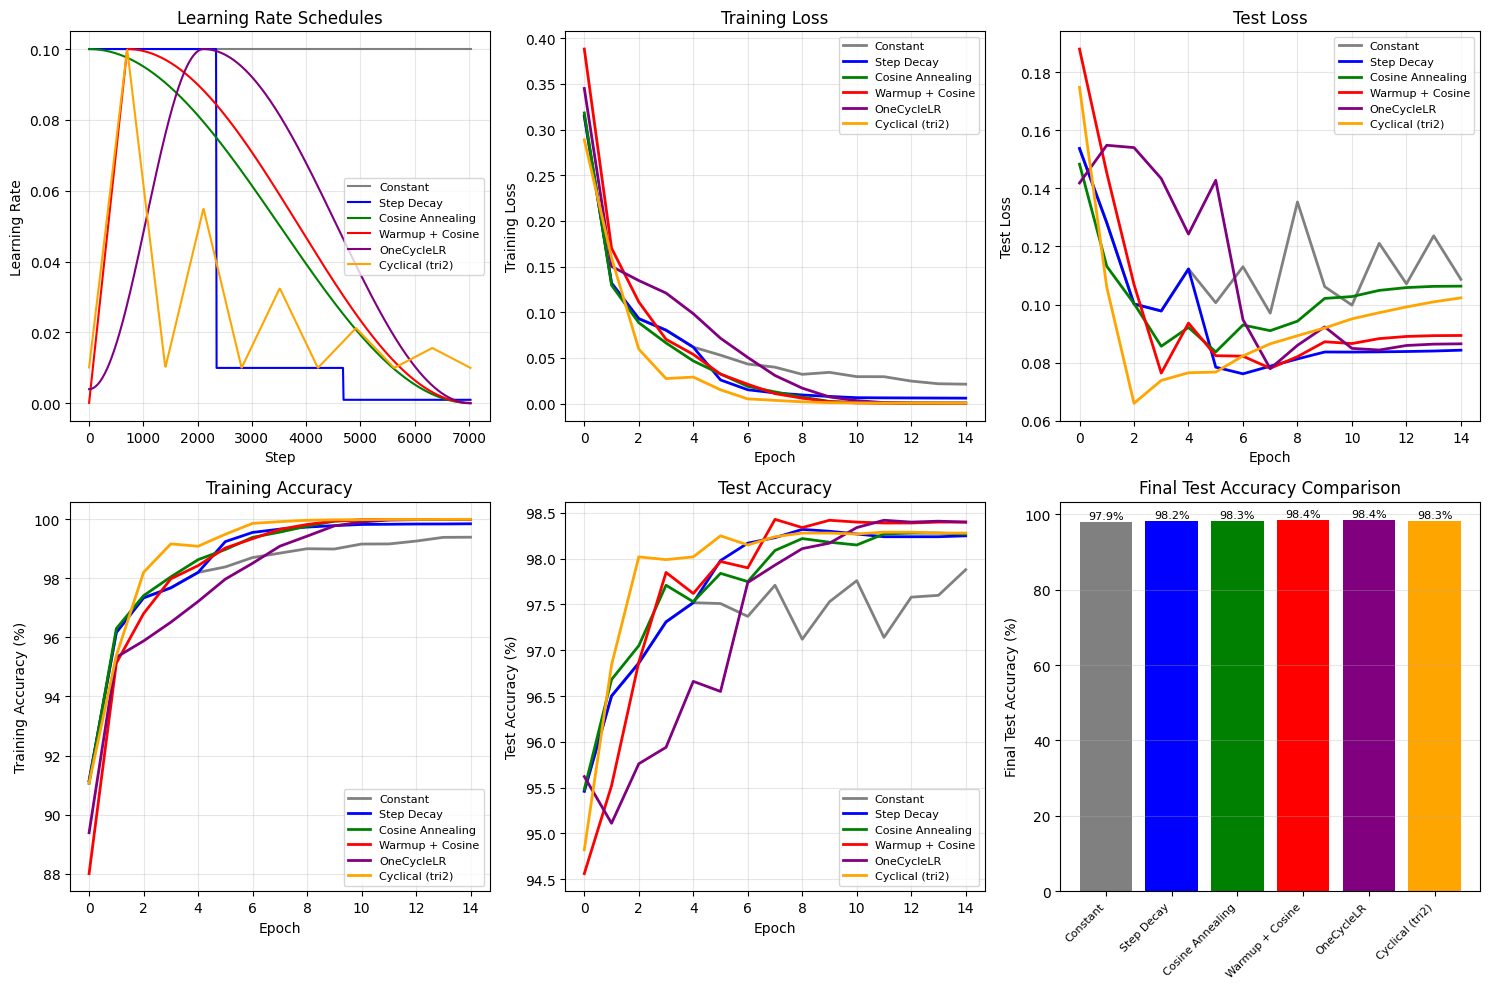

In [62]:
# Visualize training dynamics

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

colors = {
    'Constant': 'gray',
    'Step Decay': 'blue',
    'Cosine Annealing': 'green',
    'Warmup + Cosine': 'red',
    'OneCycleLR': 'purple',
    'Cyclical (tri2)': 'orange'
}

# Plot 1: Learning Rate Schedules
ax = axes[0, 0]
for name, metrics in results.items():
    # Subsample for clarity
    steps = np.arange(len(metrics.lr_history))
    ax.plot(steps[::10], metrics.lr_history[::10], label=name, color=colors[name], linewidth=1.5)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedules')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Training Loss
ax = axes[0, 1]
for name, metrics in results.items():
    ax.plot(metrics.train_losses, label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Test Loss
ax = axes[0, 2]
for name, metrics in results.items():
    ax.plot(metrics.test_losses, label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Loss')
ax.set_title('Test Loss')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Training Accuracy
ax = axes[1, 0]
for name, metrics in results.items():
    ax.plot([a*100 for a in metrics.train_accs], label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Accuracy (%)')
ax.set_title('Training Accuracy')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Test Accuracy
ax = axes[1, 1]
for name, metrics in results.items():
    ax.plot([a*100 for a in metrics.test_accs], label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Final Accuracy Comparison
ax = axes[1, 2]
names = list(results.keys())
final_accs = [results[n].test_accs[-1]*100 for n in names]
bars = ax.bar(range(len(names)), final_accs, color=[colors[n] for n in names])
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Final Test Accuracy (%)')
ax.set_title('Final Test Accuracy Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, final_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('schedule_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

EXPERIMENT 2: Step-Level Loss Dynamics

Analyzing how loss evolves at the step level with different schedules.



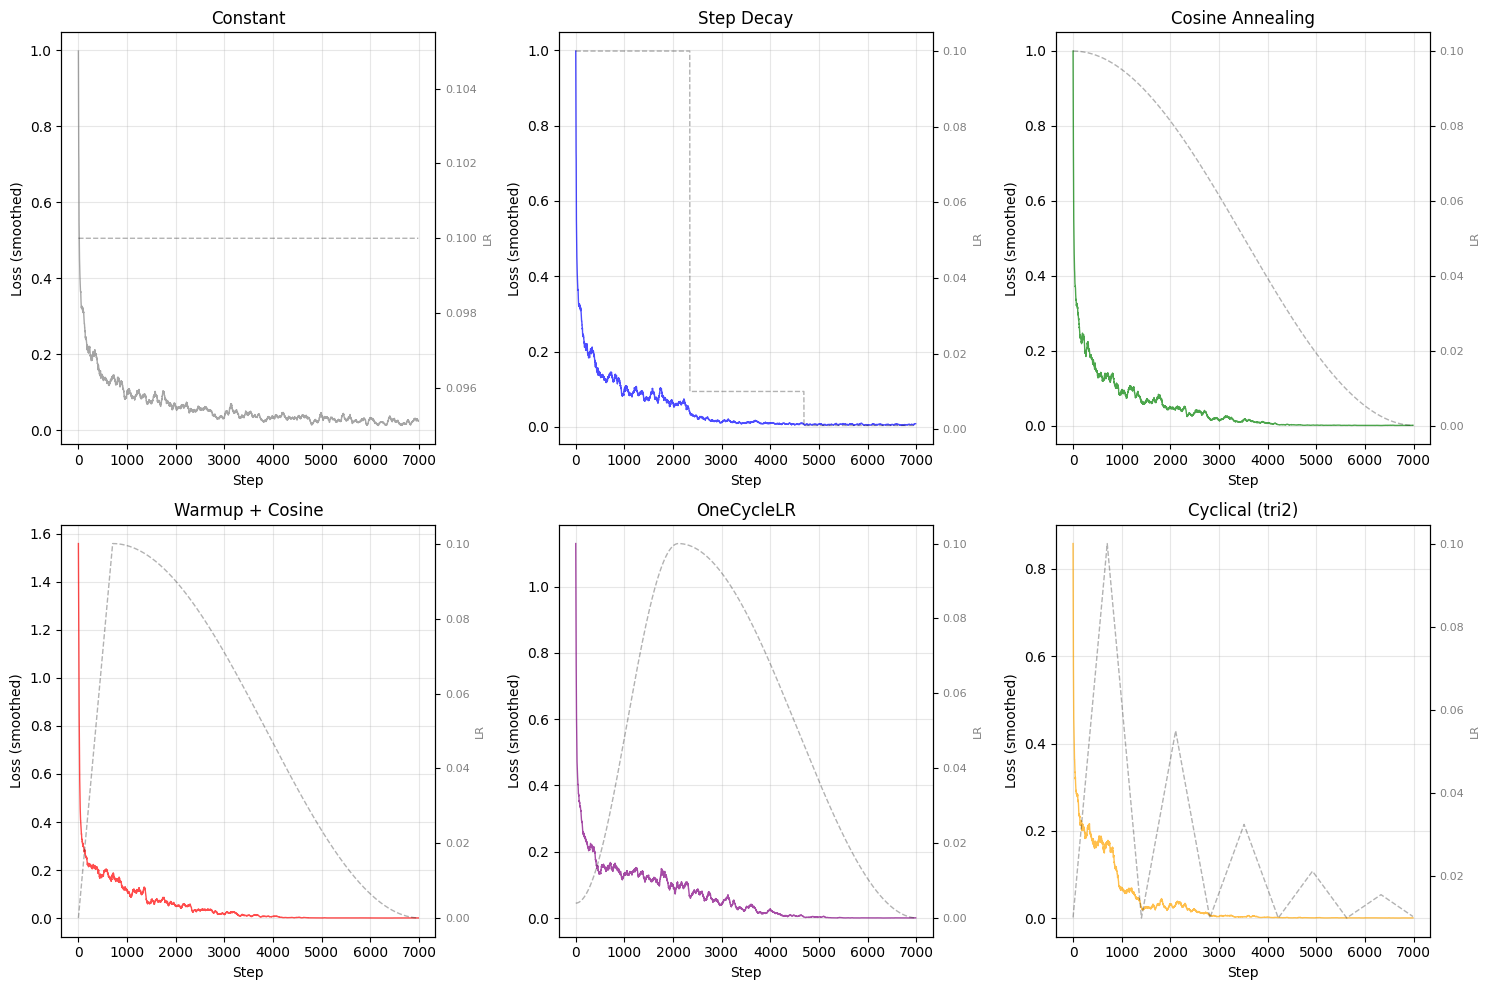

In [63]:
# Experiment 2: Step-level loss analysis

print("=" * 70)
print("EXPERIMENT 2: Step-Level Loss Dynamics")
print("=" * 70)
print("\nAnalyzing how loss evolves at the step level with different schedules.\n")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, metrics) in enumerate(results.items()):
    ax = axes[idx]

    # Smooth the step losses for visualization
    window = 50
    losses = np.array(metrics.step_losses)
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')

    ax.plot(smoothed, color=colors[name], linewidth=1, alpha=0.7)

    # Overlay LR on secondary axis
    ax2 = ax.twinx()
    lrs = np.array(metrics.lr_history[:len(smoothed)])
    ax2.plot(lrs, color='black', linewidth=1, alpha=0.3, linestyle='--')
    ax2.set_ylabel('LR', color='gray', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='gray', labelsize=8)

    ax.set_xlabel('Step')
    ax.set_ylabel('Loss (smoothed)')
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('step_level_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

In [64]:
# Experiment 3: Warmup analysis

print("=" * 70)
print("EXPERIMENT 3: Impact of Warmup Duration")
print("=" * 70)
print("\nComparing different warmup lengths with cosine decay.\n")

warmup_fractions = [0.0, 0.05, 0.1, 0.2, 0.3]
warmup_results = {}

for frac in warmup_fractions:
    name = f'Warmup {int(frac*100)}%'
    print(f"Training with {name}...")

    def make_scheduler(opt, total, f=frac):
        warmup_steps = int(total * f)
        return WarmupCosineScheduler(
            opt, base_lr=0.1, warmup_steps=max(1, warmup_steps),
            total_steps=total, min_lr=1e-4
        )

    metrics = train_with_scheduler(make_scheduler, num_epochs=10, base_lr=0.1)
    warmup_results[name] = metrics
    print(f"  Final test accuracy: {metrics.test_accs[-1]*100:.2f}%\n")

EXPERIMENT 3: Impact of Warmup Duration

Comparing different warmup lengths with cosine decay.

Training with Warmup 0%...
  Final test accuracy: 98.09%

Training with Warmup 5%...
  Final test accuracy: 98.42%

Training with Warmup 10%...
  Final test accuracy: 98.44%

Training with Warmup 20%...
  Final test accuracy: 98.31%

Training with Warmup 30%...
  Final test accuracy: 98.41%



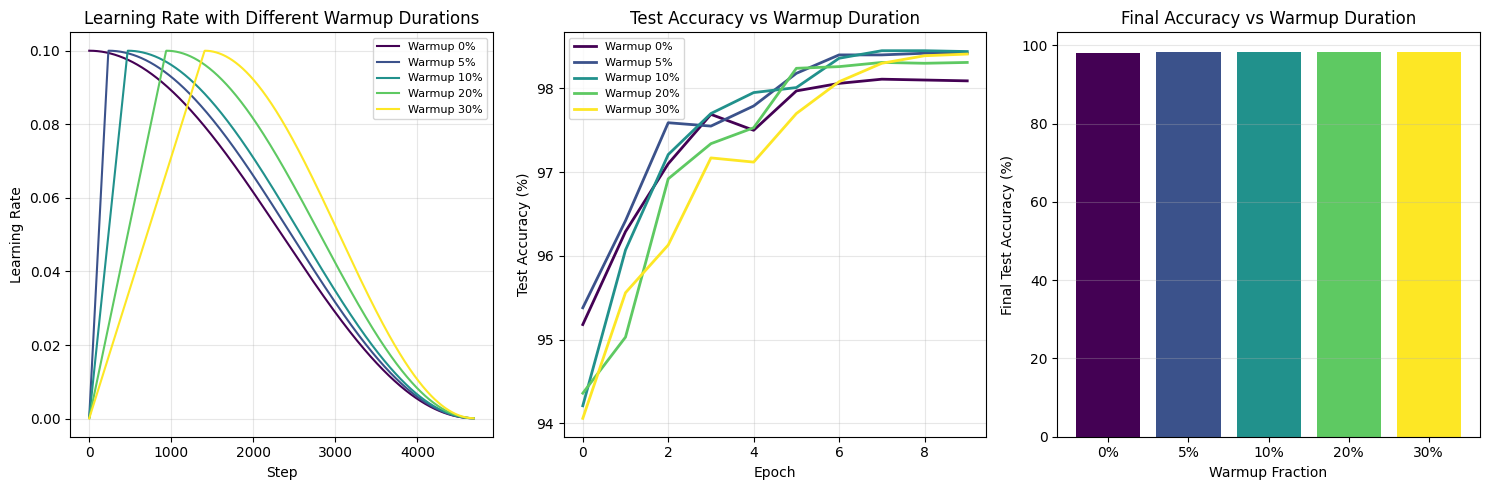

In [65]:
# Visualize warmup impact

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

warmup_colors = plt.cm.viridis(np.linspace(0, 1, len(warmup_results)))

# Plot 1: LR schedules
ax = axes[0]
for (name, metrics), color in zip(warmup_results.items(), warmup_colors):
    steps = np.arange(len(metrics.lr_history))
    ax.plot(steps[::5], metrics.lr_history[::5], label=name, color=color, linewidth=1.5)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate with Different Warmup Durations')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Test accuracy curves
ax = axes[1]
for (name, metrics), color in zip(warmup_results.items(), warmup_colors):
    ax.plot([a*100 for a in metrics.test_accs], label=name, color=color, linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy vs Warmup Duration')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Final accuracy bar chart
ax = axes[2]
names = list(warmup_results.keys())
final_accs = [warmup_results[n].test_accs[-1]*100 for n in names]
bars = ax.bar(range(len(names)), final_accs, color=warmup_colors)
ax.set_xticks(range(len(names)))
ax.set_xticklabels([n.replace('Warmup ', '') for n in names], fontsize=10)
ax.set_xlabel('Warmup Fraction')
ax.set_ylabel('Final Test Accuracy (%)')
ax.set_title('Final Accuracy vs Warmup Duration')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('warmup_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
# Experiment 4: OneCycleLR parameter sensitivity

print("=" * 70)
print("EXPERIMENT 4: OneCycleLR Parameter Sensitivity")
print("=" * 70)
print("\nExploring how max_lr affects OneCycleLR performance.\n")

max_lrs = [0.01, 0.05, 0.1, 0.2, 0.5]
onecycle_results = {}

for max_lr in max_lrs:
    name = f'max_lr={max_lr}'
    print(f"Training with {name}...")

    def make_scheduler(opt, total, mlr=max_lr):
        return OneCycleLRScheduler(
            opt, max_lr=mlr, total_steps=total, pct_start=0.3
        )

    metrics = train_with_scheduler(make_scheduler, num_epochs=10, base_lr=max_lr)
    onecycle_results[name] = metrics
    print(f"  Final test accuracy: {metrics.test_accs[-1]*100:.2f}%\n")

EXPERIMENT 4: OneCycleLR Parameter Sensitivity

Exploring how max_lr affects OneCycleLR performance.

Training with max_lr=0.01...
  Final test accuracy: 97.89%

Training with max_lr=0.05...
  Final test accuracy: 98.39%

Training with max_lr=0.1...
  Final test accuracy: 98.47%

Training with max_lr=0.2...
  Final test accuracy: 11.35%

Training with max_lr=0.5...
  Final test accuracy: 9.80%



In [67]:
# Experiment 5: Warm restarts analysis

print("=" * 70)
print("EXPERIMENT 5: Cosine Annealing with Warm Restarts (SGDR)")
print("=" * 70)
print("\nComparing different restart configurations.\n")

restart_configs = [
    ('No restarts', lambda opt, total: CosineAnnealingScheduler(
        opt, 0.1, T_max=total, eta_min=1e-4
    )),
    ('T_0=epoch, T_mult=1', lambda opt, total: CosineAnnealingWarmRestartsScheduler(
        opt, 0.1, T_0=total//15, T_mult=1, eta_min=1e-4
    )),
    ('T_0=epoch, T_mult=2', lambda opt, total: CosineAnnealingWarmRestartsScheduler(
        opt, 0.1, T_0=total//15, T_mult=2, eta_min=1e-4
    )),
]

restart_results = {}

for name, factory in restart_configs:
    print(f"Training with {name}...")
    metrics = train_with_scheduler(factory, num_epochs=15, base_lr=0.1)
    restart_results[name] = metrics
    print(f"  Final test accuracy: {metrics.test_accs[-1]*100:.2f}%\n")

EXPERIMENT 5: Cosine Annealing with Warm Restarts (SGDR)

Comparing different restart configurations.

Training with No restarts...
  Final test accuracy: 98.27%

Training with T_0=epoch, T_mult=1...
  Final test accuracy: 98.15%

Training with T_0=epoch, T_mult=2...
  Final test accuracy: 98.25%



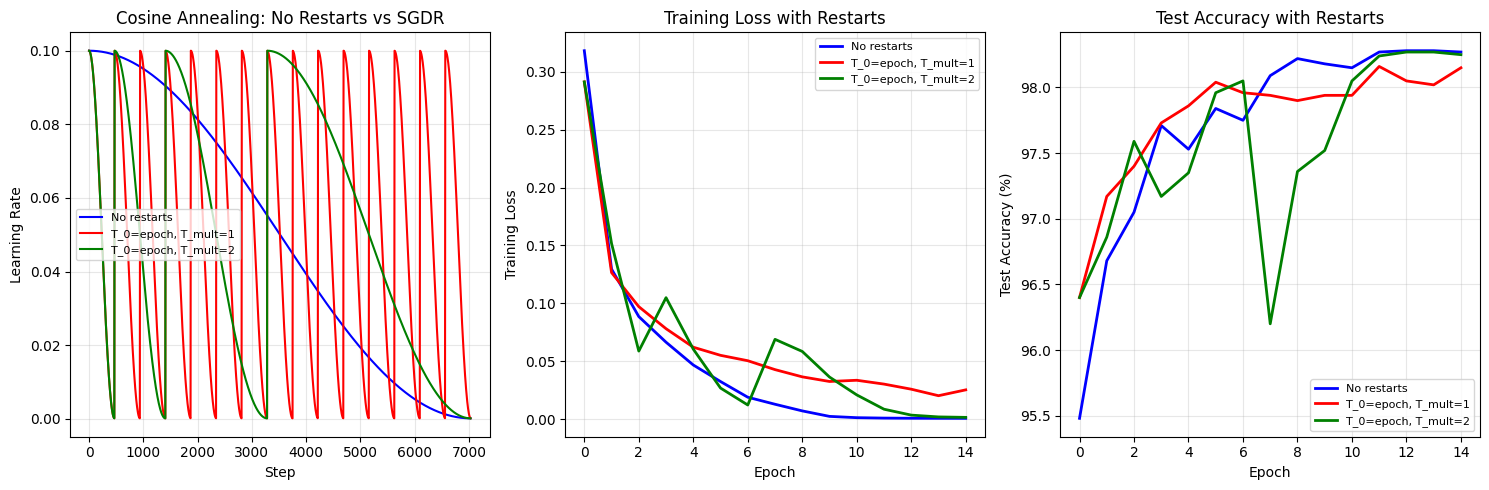

In [68]:
# Visualize warm restarts

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

restart_colors = ['blue', 'red', 'green']

# Plot 1: LR schedules
ax = axes[0]
for (name, metrics), color in zip(restart_results.items(), restart_colors):
    steps = np.arange(len(metrics.lr_history))
    ax.plot(steps[::5], metrics.lr_history[::5], label=name, color=color, linewidth=1.5)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('Cosine Annealing: No Restarts vs SGDR')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Training loss
ax = axes[1]
for (name, metrics), color in zip(restart_results.items(), restart_colors):
    ax.plot(metrics.train_losses, label=name, color=color, linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss with Restarts')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Test accuracy
ax = axes[2]
for (name, metrics), color in zip(restart_results.items(), restart_colors):
    ax.plot([a*100 for a in metrics.test_accs], label=name, color=color, linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy with Restarts')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('warm_restarts.png', dpi=150, bbox_inches='tight')
plt.show()

Learning rate scheduling interacts critically with NAS in several ways:

**Weight Sharing Dynamics**: In one-shot NAS (e.g., DARTS), all candidate architectures share weights. The learning rate schedule affects how quickly shared weights converge, which in turn affects architecture ranking accuracy. A schedule optimized for final performance may not be optimal for architecture selection.

**Search vs. Evaluation Schedules**: Often, different schedules are used during search (shorter, simpler) and final evaluation (longer, more sophisticated). This discrepancy can cause ranking inconsistencies—architectures that perform well under one schedule may not under another.

**Multi-Agent Learning**: In MARL-NAS frameworks, different agents controlling different architecture dimensions may benefit from different learning rate dynamics. Coordinating schedules across agents is an open research question.
